<h1 style='color: green; font-size: 26px; font-weight: bold;'> 3. Previsão de falha <h1>

### Notebook 2
1.  Pré Processamento II
2. Feature engineering
3. Modelagem
4. Avaliação
5. Modelo final
6. Conclusão.

<strong>Descripción</strong>
<p>Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten
diariamente telemetría agregada en varios atributos.
Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la
condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el
mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo
de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.
</p>

<strong>Entregable</strong>
<p>Tiene la tarea de generar una Jupyter notebook con un modelo predictivo para predecir la
probabilidad de falla del dispositivo con el objetivo de bajar los costos del proceso. Como
una referencia, una falla de un dispositivo tiene un costo de 1 mientras el costo de un
mantenimiento es 0,5. El archivo "full_devices.csv" tiene los valores diários para los 9
atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con
el valor binario 0 para no fallar y 1 para fallar
</p>

# Carregando os dados

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [2]:
dir_data = "F:\PycharmProjects\DesaioMELI\data"
df = pd.read_csv(dir_data+r'\full_devices.csv', sep=',', encoding='ISO-8859-1')
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


coluna 'failure'
1 = Equipamento falhou
0 = Equipamento não falhou

'device'
equipamento monitorado

'attribute1'
pode ser algum código, não tenho certeza.


In [3]:
df.nunique()

date             304
device          1169
failure            2
attribute1    123877
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

In [4]:
df.groupby(['device']).agg(['count']).shape

(1169, 11)

In [5]:
df.groupby(['date']).agg(['count']).shape

(304, 11)

# Pré processamento II

In [6]:
#Tranformando os tipos de dados
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [7]:
df = df.drop_duplicates()

Eliminando o registro duplicado identificado no notebook 1

In [8]:
df.shape

(124493, 12)

In [9]:
df.groupby(['failure'])['device'].count()

failure
0    124387
1       106
Name: device, dtype: int64

In [10]:
#percentual de falha em 11 meses
print('Percentual de falha: {:.5f}%'.format(df.groupby(['failure'])['device'].count().iloc[1] / df['device'].count()))

Percentual de falha: 0.00085%


In [11]:
#ordenando o dataset por data e pelo device para posteriormente verificar o histórico até a falha
df = df.sort_values(by=['device','date'], ascending=[True, True])
df['flipper'] = np.where((df.device != df.device.shift(1)), 1, 0)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0


<strong>Pensando no oversampling, somente duplicar os dados pode gerar overfitting, pois existe um tempo de vida para cada dispositivo e um período de uso para falha, visto que não é um evento comum, então introduzir somente os registros de falhas, sem considerar os dados que antecem o evento resultará em um viés que acarretará em overfitting. O viés é inevitavél, mas o ideal é que acompanhe o comportamento dos dados.</strong>

Dito isso, vou criar algumas features para obter essa informação de comportamento dos dados até a falha e com isso gerar os novos registros, além de tranformar os dados de colunas para melhor se adequarem a modelagem.

In [12]:
#pega o 1º registro para cada dispositivo, com a coluna criada 'flipper'
starter = df[df['flipper'] == 1]
starter = starter[['date','device']]
starter = starter.rename(index=str, columns={"date": "start_date"})
starter['start_date'] = pd.to_datetime(starter['start_date'])

In [13]:
#Merge start_date com o dataset original, para marcar a data de inicio de monitoramento de cada dispositivo
df = df.sort_values(by=['device', 'date'], ascending=[True, True])
starter = starter.sort_values(by=['device'], ascending=[True])
df = df.merge(starter, on=['device'], how='left')

In [14]:
df[df['failure'] == 1].groupby(['date','start_date'])['device'].count()

date        start_date
2015-01-05  2015-01-01    1
2015-01-07  2015-01-01    1
2015-01-09  2015-01-01    1
2015-01-13  2015-01-01    1
2015-01-14  2015-01-01    1
                         ..
2015-08-04  2015-01-01    1
2015-08-18  2015-01-01    1
2015-10-05  2015-01-01    1
2015-10-09  2015-01-01    1
2015-10-26  2015-01-01    1
Name: device, Length: 76, dtype: int64

In [15]:
# Calcula os dias até a falha para cada dispositivo, contando a partir do momento que se iniciou a monitoria do dispositivo
#Isso irá servir para encontrar o valor do ciclo para usar como janela no agrupamento
devices = df['device'].unique()
failure_record = []
no_failured = []
for device in devices:
    start_date = df.loc[(df['device'] == device) & (df['flipper'] == 1), 'date'].iloc[0]
    falhas_dispositivo = df.loc[(df['device'] == device) & (df['failure'] == 1), 'date']
    if not falhas_dispositivo.empty:
        data_falha = falhas_dispositivo.min()
        dias_decorridos = (data_falha - start_date).days
        failure_record.append({
            'device': device,
            'count_days': dias_decorridos,
            'start_date': start_date,
            'failure_date': data_falha.date()
        })
    else:
        no_failured.append({
            'device': device,
            'start_date': start_date,
        })

In [16]:
#Dataframe com os dispositivos que falharam e outro com os que não falharam
df_failured_record = pd.DataFrame(failure_record).sort_values(by='failure_date').reset_index(drop=True)
df_non_failured_record = pd.DataFrame(no_failured).sort_values(by='start_date').reset_index(drop=True)

In [17]:
df_non_failured_record

,device,start_date
0,S1F01085,2015-01-01
1,W1F0X5L3,2015-01-01
2,W1F0X5L8,2015-01-01
3,W1F0X5N2,2015-01-01
4,W1F0X5TL,2015-01-01
...,...,...
1058,S1F02W1L,2015-05-06
1059,S1F02XLX,2015-05-06
1060,S1F013BB,2015-05-06
1061,S1F03499,2015-05-06


In [18]:
df_failured_record

,device,count_days,start_date,failure_date
0,S1F0RRB1,4,2015-01-01,2015-01-05
1,S1F0CTDN,6,2015-01-01,2015-01-07
2,W1F0PNA5,8,2015-01-01,2015-01-09
3,W1F13SRV,12,2015-01-01,2015-01-13
4,W1F1230J,13,2015-01-01,2015-01-14
...,...,...,...,...
101,W1F1CB5E,215,2015-01-01,2015-08-04
102,Z1F0MRPJ,229,2015-01-01,2015-08-18
103,S1F0JGJV,277,2015-01-01,2015-10-05
104,Z1F14BGY,281,2015-01-01,2015-10-09


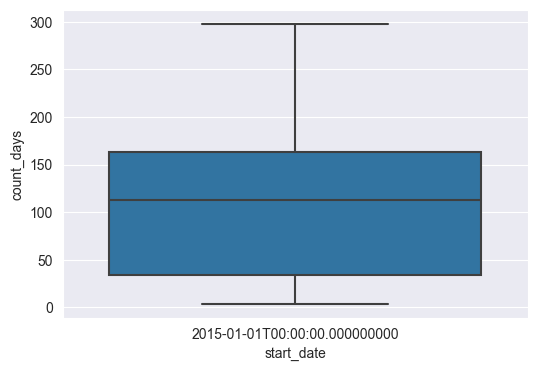

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(x= 'start_date',y='count_days',data=df_failured_record)
plt.show()

array([[<Axes: title={'center': 'count_days'}>,
        <Axes: title={'center': 'start_date'}>]], dtype=object)

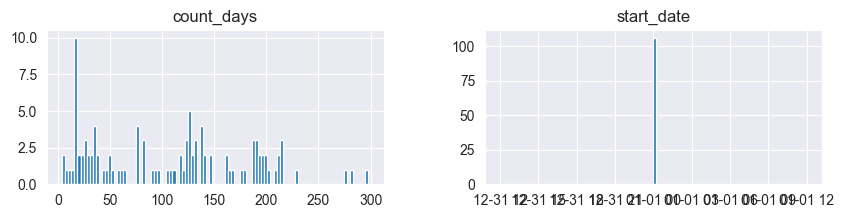

In [20]:
#Distribuição dos dispositivos que falharam em dias corrido a partir do inicio da monitoria de cada um
ax = df_failured_record.hist(bins=100, figsize=(10,2))
ax

In [21]:
df_failured_record.describe()

,count_days
count,106.000000
mean,106.905660
std,74.017826
min,4.000000
25%,34.000000
50%,113.000000
75%,163.250000
max,298.000000


In [22]:
#mediana
df_failured_record.mode()

,device,count_days,start_date,failure_date
0,S1F023H2,18.0,2015-01-01,2015-01-19
1,S1F03YZM,NaN,NaT,NaN
2,S1F09DZQ,NaN,NaT,NaN
3,S1F0CTDN,NaN,NaT,NaN
4,S1F0DSTY,NaN,NaT,NaN
...,...,...,...,...
101,Z1F1901P,NaN,NaT,NaN
102,Z1F1AG5N,NaN,NaT,NaN
103,Z1F1FCH5,NaN,NaT,NaN
104,Z1F1RJFA,NaN,NaT,NaN


In [23]:
#Falhas ranqueada por data
df_failured_record.groupby('failure_date')['device'].count().sort_values(ascending=False)

failure_date
2015-01-19    8
2015-05-08    3
2015-02-04    3
2015-07-20    2
2015-03-17    2
             ..
2015-04-20    1
2015-04-21    1
2015-04-27    1
2015-01-07    1
2015-10-26    1
Name: device, Length: 76, dtype: int64

Todos os dispositivos que falharam são monitorados desde o dia 01-01 e 75% deles falharam em até 163 dias após essa data.
O dia que mais dispositivos falharam aconteceu 18 dias após a data de inicio da monitoria, no total foram 8 dispositivos.
Vou utilizar essa janela de dias para fazer a Sobreamostragem e agregação dos dados dos sensores.

# Feature engineering

### Novas colunas auxiliares

In [24]:
#Esta é a janela pela qual será feita a agregação dos valores das colunas.
window = 18

In [25]:
#pegando o primeiro registro para cada máqui, com a coluna flipper
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper,start_date
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1,2015-01-01
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0,2015-01-01
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0,2015-01-01
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0,2015-01-01
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0,2015-01-01


In [26]:
#Calcula o número de dias corridos para cada dispositivo até atingir 'window',
df['count_days'] = df['date'] - df['start_date']
df['time_since_start'] = df['count_days'] / np.timedelta64(1, 'D')
df = df.drop(columns=['count_days'])
# quando valor for 1, o histórico de monitoramento do dispositivo tem menos que 18 dias
df['too_soon'] = np.where((df.time_since_start < window) , 1, 0)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper,start_date,time_since_start,too_soon
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1,2015-01-01,0.0,1
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0,2015-01-01,1.0,1
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0,2015-01-01,2.0,1
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0,2015-01-01,3.0,1
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0,2015-01-01,4.0,1


In [27]:
#Drop da coluna attribute8 por ter correlação perfeita positiva com a attribute9
df.drop('attribute8', axis=1, inplace=True)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,start_date,time_since_start,too_soon
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,1,2015-01-01,0.0,1
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,0,2015-01-01,1.0,1
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,0,2015-01-01,2.0,1
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,0,2015-01-01,3.0,1
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,0,2015-01-01,4.0,1


### Oversamplig - gerando mais casos de falha para balanceamento das classes

No primeiro momento vou testar a janela encontrada com a moda da coluna de datas para falhas.
A técnica será a de SMOTE (Synthetic Minority Over-sampling Technique), ela gera amostras sintéticas da classe minoritária. Para cada exemplo da classe minoritária é selecionado aleatóriamente um valor k vizinhos mais próximos para criar novos exemplos. Usarei a janela (18) para K e a quantidade de amostras ((taxa de oversampling) será determinada pela razão: (tamanho_nao_falhas / tamanho_falhas) - 1) / 10.

In [28]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime


#trasformação da coluna de dispositivos
encoder = LabelEncoder()

df['device_encolder'] = encoder.fit_transform(df['device'])
print('Quantidade de device: {} e device Encoder: {}'.format(df['device'].nunique(), df['device_encolder'].nunique()))
df.drop('device', axis=1, inplace=True)

#colunas de datas precisam ser convertidas
df["date"] = (pd.to_datetime(df["date"]) - datetime(1970, 1, 1)).dt.total_seconds()
df["start_date"] = (pd.to_datetime(df["start_date"]) - datetime(1970, 1, 1)).dt.total_seconds()

Quantidade de device: 1169 e device Encoder: 1169


In [29]:
from collections import Counter
from imblearn.over_sampling import SMOTE

def oversamplit_SMOTE(data, tx):
    # Separando as features e o target
    X = data.drop('failure', axis=1)
    y = data['failure']

    # Verifique a contagem de classe antes do oversampling
    print('Contagem de classe antes do oversampling:', Counter(y))

    # Determine a taxa de oversampling
    minority_class_size = len(data[data['failure'] == 1])
    majority_class_size = len(data[data['failure'] == 0])
    oversampling_rate = (1 - (minority_class_size / majority_class_size)) * tx

    # Use SMOTE para gerar amostras sintéticas com a taxa de oversampling
    smote = SMOTE(sampling_strategy=oversampling_rate, k_neighbors=18, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Verifique a contagem de classe depois do oversampling
    print('Contagem de classe depois do oversampling:', Counter(y_resampled))
    print(y_resampled.mean())
    # Criando um novo DataFrame com as features resampleadas e o target resampleado
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled['failure'] = y_resampled
    return df_resampled

df_resampled = oversamplit_SMOTE(df, 0.05)

Contagem de classe antes do oversampling: Counter({0: 124387, 1: 106})
Contagem de classe depois do oversampling: Counter({0: 124387, 1: 6214})
0.04758003384353872


O percentual de falha original é: 0.83%, com Oversample ficou em 5%. Ainda está muito desbalanceado, por enquanto irei manter essas quantidades, para não introduzir um viés alto antes de fazer o split entre treino e teste. Depois desse split, vou fazer o SMOTE de novo para gerar noso registros no dataset de treino.

In [30]:


df_resampled.shape


(130601, 15)

<Axes: xlabel='failure', ylabel='count'>

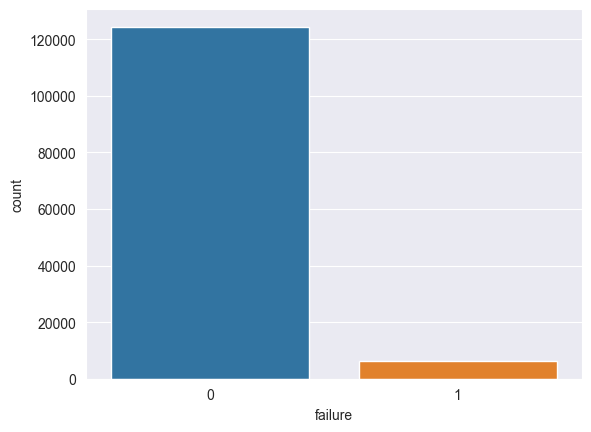

In [31]:
sns.countplot(data=df_resampled, x='failure')

In [32]:
#ordenando novamente pelo device e date
df_resampled.sort_values(by=['device_encolder','date'], ascending=[True, True]).head(30)

,date,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,start_date,time_since_start,too_soon,device_encolder,failure
0,1.420070e+09,215630672,56,0,52,6,407438,0,7,1,1.420070e+09,0.0,1,0,0
1,1.420157e+09,1650864,56,0,52,6,407438,0,7,0,1.420070e+09,1.0,1,0,0
2,1.420243e+09,124017368,56,0,52,6,407438,0,7,0,1.420070e+09,2.0,1,0,0
3,1.420330e+09,128073224,56,0,52,6,407439,0,7,0,1.420070e+09,3.0,1,0,0
4,1.420416e+09,97393448,56,0,52,6,408114,0,7,0,1.420070e+09,4.0,1,0,0
5,1.420502e+09,128832128,56,0,52,6,409404,0,7,0,1.420070e+09,5.0,1,0,0
6,1.430870e+09,14533968,0,0,0,5,688952,0,0,1,1.430870e+09,0.0,1,1,0
7,1.430957e+09,46202296,0,0,0,5,688952,0,0,0,1.430870e+09,1.0,1,1,0
8,1.431043e+09,214383720,0,0,0,5,688964,0,0,0,1.430870e+09,2.0,1,1,0
9,1.431130e+09,243346080,0,0,0,5,689035,0,0,0,1.430870e+09,3.0,1,1,0


### Tranformação dos dados

Os dados são bem dispersos, então para a transformação vou utilizar a média, mediana, o máximo e o minímo das colunas de telemetria.

In [33]:
def tranform_new_data(colum):
    df_resampled[colum+'_mean'] =np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1,window=window).mean()), df_resampled[colum])
    df_resampled[colum+'_median'] =np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1,window=window).median()), df_resampled[colum])
    df_resampled[colum+'_max'] = np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1, window=window).max()), df_resampled[colum])
    df_resampled[colum+'_min'] = np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1, window=window).min()), df_resampled[colum])

#Colunas para transformação
for i in df_resampled.columns[1:9]:
    tranform_new_data(df_resampled[i].name)

In [34]:
df_resampled.head()

,date,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,...,attribute6_max,attribute6_min,attribute7_mean,attribute7_median,attribute7_max,attribute7_min,attribute9_mean,attribute9_median,attribute9_max,attribute9_min
0,1.420070e+09,215630672,56,0,52,6,407438,0,7,1,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
1,1.420157e+09,1650864,56,0,52,6,407438,0,7,0,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
2,1.420243e+09,124017368,56,0,52,6,407438,0,7,0,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
3,1.420330e+09,128073224,56,0,52,6,407439,0,7,0,...,407439.0,407439.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
4,1.420416e+09,97393448,56,0,52,6,408114,0,7,0,...,408114.0,408114.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0


Detectando os valores de pico para cada coluna, criando um valor que indica a distância entre o valor atual e a norma no intante avaliado.

In [35]:
df_resampled['attribute1_chg'] = np.where((df_resampled.attribute1_mean == 0),0 , df_resampled.attribute1/df_resampled.attribute1_mean)
df_resampled['attribute2_chg'] = np.where((df_resampled.attribute2_mean == 0),0 , df_resampled.attribute2/df_resampled.attribute2_mean)
df_resampled['attribute3_chg'] = np.where((df_resampled.attribute3_mean == 0),0 , df_resampled.attribute3/df_resampled.attribute3_mean)
df_resampled['attribute4_chg'] = np.where((df_resampled.attribute4_mean == 0),0 , df_resampled.attribute4/df_resampled.attribute4_mean)
df_resampled['attribute5_chg'] = np.where((df_resampled.attribute5_mean == 0),0 , df_resampled.attribute5/df_resampled.attribute5_mean)
df_resampled['attribute6_chg'] = np.where((df_resampled.attribute6_mean == 0),0 , df_resampled.attribute6/df_resampled.attribute6_mean)
df_resampled['attribute7_chg'] = np.where((df_resampled.attribute7_mean == 0),0 , df_resampled.attribute7/df_resampled.attribute7_mean)
df_resampled['attribute9_chg'] = np.where((df_resampled.attribute9_mean == 0),0 , df_resampled.attribute9/df_resampled.attribute9_mean)

In [36]:
df_resampled.head()


,date,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,...,attribute9_max,attribute9_min,attribute1_chg,attribute2_chg,attribute3_chg,attribute4_chg,attribute5_chg,attribute6_chg,attribute7_chg,attribute9_chg
0,1.420070e+09,215630672,56,0,52,6,407438,0,7,1,...,7.0,7.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,1.420157e+09,1650864,56,0,52,6,407438,0,7,0,...,7.0,7.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,1.420243e+09,124017368,56,0,52,6,407438,0,7,0,...,7.0,7.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
3,1.420330e+09,128073224,56,0,52,6,407439,0,7,0,...,7.0,7.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
4,1.420416e+09,97393448,56,0,52,6,408114,0,7,0,...,7.0,7.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [37]:
df = df_resampled

### Separação dos dados entre treino e teste por estratificação

In [38]:
from sklearn.model_selection import train_test_split
# Separando as features e o target
X = df.drop('failure', axis=1)
y = df['failure']
stratify_col = df['device_encolder']

# dividindo o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify_col, test_size=0.15, random_state=45)

# Verificando as proporções das classes nos conjuntos de treino e teste
print('Proporção de classe no conjunto de treino:', y_train.value_counts(normalize=True))
print('Proporção de classe no conjunto de teste:', y_test.value_counts(normalize=True))

# Exibindo a quantidade de registros em cada conjunto de dados
print('\nNúmero de registros no conjunto de treino:', len(X_train))
print('Número de registros no conjunto de teste:', len(X_test))

# Exibindo a contagem de valores únicos na coluna 'failure' para cada conjunto de dados
print('\nContagem de valores failure no conjunto de treino:')
print(y_train.value_counts())

print('\nContagem de valores failure no conjunto de teste:')
print(y_test.value_counts())

Proporção de classe no conjunto de treino: 0    0.952446
1    0.047554
Name: failure, dtype: float64
Proporção de classe no conjunto de teste: 0    0.952274
1    0.047726
Name: failure, dtype: float64

Número de registros no conjunto de treino: 111010
Número de registros no conjunto de teste: 19591

Contagem de valores failure no conjunto de treino:
0    105731
1      5279
Name: failure, dtype: int64

Contagem de valores failure no conjunto de teste:
0    18656
1      935
Name: failure, dtype: int64


In [39]:
#Tranformando novamente as colunas de data
# df_resampled['date'] = pd.to_datetime(df_resampled['date'],unit='s')
# df_resampled['start_date'] = pd.to_datetime(df_resampled['start_date'],unit='s')
#
# df_resampled['start_date'] = df_resampled['start_date'].dt.strftime('%Y-%m-%d')
# df_resampled['date'] = df_resampled['date'].dt.strftime('%Y-%m-%d')

### Oversampling mais intenso com SMOTE nos dados de treino

In [40]:
# Concatenando as features e o target
train_df = pd.concat([X_train, y_train], axis=1)
# Chamando a função de Oversampling, agora permitindo uma taxa maior
train_df = oversamplit_SMOTE(train_df, 1)

Contagem de classe antes do oversampling: Counter({0: 105731, 1: 5279})
Contagem de classe depois do oversampling: Counter({0: 105731, 1: 100452})
0.48719826561840696


agora irei trabalhar com esse novo dataset para treinamento dos modelos - train_df

##### Inicialmente, irei utilizar todas colunas para avaliação de Feaute importance.

In [41]:
# Separando as features e o target
X2 = train_df.drop('failure', axis=1)
y2 = train_df['failure']
stratify_col2 = train_df['device_encolder']

# dividindo o conjunto de dados em treino e teste com estratificação
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=stratify_col2, test_size=0.20, random_state=45)

# Exibindo a contagem de valores únicos na coluna 'failure' para cada conjunto de dados
print('\nContagem de valores failure no conjunto de treino:')
print(y_train2.value_counts())

print('\nContagem de valores failure no conjunto de teste:')
print(y_test2.value_counts())


Contagem de valores failure no conjunto de treino:
0    84616
1    80330
Name: failure, dtype: int64

Contagem de valores failure no conjunto de teste:
0    21115
1    20122
Name: failure, dtype: int64


# Modelagem - escolha do limiar

In [42]:
#imports das bibliotecas para treinar os modelos
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [43]:
# Função para chamar o pipeline de predição e gerar a confusion matrix
def prediction_pipe(clf):
  clf.fit(X_train2, y_train2)
  y_pred = clf.predict(X_test2)
  cm = confusion_matrix(y_test2, y_pred, labels=clf.classes_, normalize='all')
  print('F1 Score:', f1_score(y_test2, y_pred))
  print('Matriz de confusão: \n', cm, '\n')
  print("===============================================")

In [44]:

# Aplicando pipelines de modelos para diferentes classificadores
pipeline_lr = Pipeline([('lr_classifier',LogisticRegression())])
# pipeline_svm = Pipeline([('svm_classifier',SVC())])
pipeline_dt = Pipeline([('dt_classifier',DecisionTreeClassifier())])
pipeline_gbcl = Pipeline([('gbcl_classifier',GradientBoostingClassifier())])
pipeline_rf = Pipeline([('rf_classifier',RandomForestClassifier())])
pipeline_knn = Pipeline([('knn_classifier',KNeighborsClassifier())])


# Aplicando modelos

pipelines = {'Logistic Regression':pipeline_lr, 'Decision Tree':pipeline_dt, 'Gradient Boosting':pipeline_gbcl, 'Random Forest':pipeline_rf, 'KNeighbors':pipeline_knn }
for k, pipe in pipelines.items():
  print(k)
  prediction_pipe(pipe)

Logistic Regression


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score: 0.9810798570925375
Matriz de confusão: 
 [[0.5089604  0.00307976]
 [0.01515629 0.47280355]] 

Decision Tree
F1 Score: 0.9991300241107602
Matriz de confusão: 
 [[5.11773407e-01 2.66750734e-04]
 [5.82001601e-04 4.87377840e-01]] 

Gradient Boosting
F1 Score: 0.9992541395256327
Matriz de confusão: 
 [[5.11943158e-01 9.70002668e-05]
 [6.30501734e-04 4.87329340e-01]] 

Random Forest
F1 Score: 0.9992292966710589
Matriz de confusão: 
 [[5.11918908e-01 1.21250333e-04]
 [6.30501734e-04 4.87329340e-01]] 

KNeighbors
F1 Score: 0.9108376412461686
Matriz de confusão: 
 [[0.42265441 0.08938575]
 [0.00514101 0.48281883]] 



In [45]:

# Aplicando o Random Forest
clf = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_test2)

In [46]:
#Agora o teste com o outro dataset de teste que separei no primeiro Oversampling
print(classification_report(y_test2, clf.predict(X_test2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21115
           1       1.00      1.00      1.00     20122

    accuracy                           1.00     41237
   macro avg       1.00      1.00      1.00     41237
weighted avg       1.00      1.00      1.00     41237



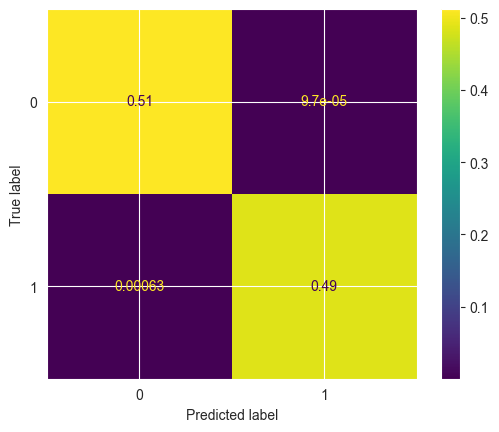

In [48]:

# Matriz de confusão
cm = confusion_matrix(y_test2, y_pred, labels=clf.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### RandomSearch para o RandomForestClassifier

In [50]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

forest_reg = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = forest_reg, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=45,  scoring='recall')
# Fit the random search model
rf_random.fit(X_train2, y_train2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90; total time=  27.4s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90; total time=  27.6s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90; total time=  27.2s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90; total time=  26.5s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90; total time=  26.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  19.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  19.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  19.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  18.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  19.4s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  21.5s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  20.4s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  21.7s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  20.5s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  21.1s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90; total time=  24.0s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, m

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=90; total time=  29.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=90; total time=  28.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=90; total time=  28.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=90; total time=  27.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=90; total time=  28.5s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=  12.2s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=  12.4s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=  12.4s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=  12.5s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=  12.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  25.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  25.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  25.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  24.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  25.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  39.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  40.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  38.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  37.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  40.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30; total time=  10.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30; total time=  10.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30; total time=  10.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30; total time=  10.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30; total time=  11.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   8.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   8.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   7.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   8.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   8.5s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   4.1s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   4.0s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   3.8s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   4.0s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   3.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  24.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  24.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  25.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  24.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  24.7s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=50; total time=  13.6s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=50; total time=  13.6s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=50; total time=  13.7s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=50; total time=  13.7s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=50; total time=  13.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=  23.9s
[CV] END bootstrap=True, max_depth=10, max_feature

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  21.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  21.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  21.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  20.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  21.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  32.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  33.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  33.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  32.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  33.2s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   8.3s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   8.0s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   7.4s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   7.9s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   7.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  35.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  34.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  34.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  34.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  35.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=30; total time=  10.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=30; total time=   9.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=30; total time=  10.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=30; total time=   9.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=30; total time=   9.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=  19.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=  19.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=  19.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=  19.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=  20.2s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  30.3s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  30.1s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  29.0s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  27.7s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  28.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  18.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  17.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  17.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  17.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  17.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=  25.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=  25.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=  25.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=  24.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=  24.5s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60; total time=  23.2s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60; total time=  24.5s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60; total time=  23.9s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60; total time=  23.7s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=60; total time=  24.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  43.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  45.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  43.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  42.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  45.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=70; total time=  22.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=70; total time=  22.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=70; total time=  21.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=70; total time=  22.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=70; total time=  22.0s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   3.4s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   3.5s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   3.7s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   3.6s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   3.5s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=30; total time=  12.0s
[CV] END bootstrap=False, max_depth=8, max_features=sq

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=  28.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=  28.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=  27.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=  27.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=  29.2s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   5.6s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   5.4s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   5.7s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   5.6s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   6.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  23.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  24.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  24.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  24.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  27.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   5.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   6.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   5.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   5.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   5.4s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=  25.7s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=  26.1s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=  26.2s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=  24.2s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=  25.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=10; total time=   3.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=10; total time=   3.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=10; total time=   3.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=10; total time=   4.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=10; total time=   4.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  39.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  33.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  33.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  33.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  32.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=10; total time=   4.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=10; total time=   3.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=10; total time=   3.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=10; total time=   3.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=10; total time=   3.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=90; total time=  35.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=90; total time=  35.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=90; total time=  31.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=90; total time=  33.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=90; total time=  33.4s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=  27.9s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=  28.4s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=  30.2s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=  27.5s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=  29.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   3.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   3.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   3.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   3.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   3.2s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=30; total time=  11.5s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=30; total time=  12.5s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=30; total time=  11.9s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=30; total time=  11.7s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=30; total time=  10.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  20.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  20.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  26.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  21.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  21.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  20.6s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  20.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  21.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  20.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  20.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=40; total time=  12.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=40; total time=  12.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=40; total time=  12.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=40; total time=  12.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=40; total time=  12.5s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  26.0s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  27.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  26.3s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  25.8s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  26.5s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   3.2s
[CV] END bootstrap=False, max_depth=6, max_features=sqr

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   6.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   5.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   5.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   5.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   5.6s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  31.0s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  31.6s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  32.6s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  31.9s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  34.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  22.4s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt,

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  22.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  21.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  23.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  20.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  22.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   2.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   3.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   3.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   2.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   3.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  34.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  37.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  34.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  33.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  35.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time=  12.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time=  11.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time=  11.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time=  10.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30; total time=  11.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  28.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  29.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  31.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  29.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  29.2s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  18.8s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  19.9s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  20.6s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  19.2s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  20.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  32.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  31.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  31.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  31.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=80; total time=  32.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   3.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time=  37.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time=  35.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time=  36.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time=  33.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time=  32.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  29.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  28.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  29.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  28.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=  29.8s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  26.1s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  26.4s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  24.2s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  25.3s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70; total time=  26.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  24.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  25.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  24.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  23.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  22.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   7.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   7.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   7.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   7.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=20; total time=   7.9s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  11.6s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  11.7s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  11.4s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  12.3s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  12.2s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90; total time=  31.0s
[CV] END bootstrap=False, max_depth=6, max_features=s

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=20; total time=   7.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=20; total time=   9.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=20; total time=   9.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=20; total time=   8.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=20; total time=   7.8s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  26.9s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  27.8s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  27.1s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  27.7s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=  30.1s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=  33.1s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, m

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.1s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30; total time=   9.6s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30; total time=   9.6s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30; total time=   9.1s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30; total time=   9.0s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30; total time=   9.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=80; total time=  34.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, 

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  29.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  31.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  28.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  28.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=80; total time=  28.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=  36.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=  37.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=  39.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=  37.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=100; total time=  37.0s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  14.6s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  14.2s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  14.1s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  16.3s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  15.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  30.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  30.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  30.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  31.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70; total time=  32.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time=   3.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time=   2.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time=   2.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time=   2.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time=   3.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=60; total time=  29.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=60; total time=  28.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=60; total time=  27.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=60; total time=  28.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=60; total time=  27.6s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  27.5s
[CV] END bootstrap=True, max_depth

F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  12.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  13.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  13.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  13.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40; total time=  14.3s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  19.1s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  18.3s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  18.9s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  18.6s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=60; total time=  20.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  22.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  23.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  25.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  23.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70; total time=  24.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=70; total time=  22.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=70; total time=  23.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=70; total time=  23.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=70; total time=  22.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=70; total time=  21.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  23.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  22.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  22.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  21.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  22.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   2.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  29.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  28.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  28.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  26.8s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=90; total time=  28.9s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  21.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  21.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  20.7s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  22.1s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=70; total time=  20.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=  16.5s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=  17.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=  15.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=  16.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=  17.0s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=  26.3s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=  26.6s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=  27.4s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=  26.2s


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=  26.8s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 5, 6, 6, 7, 7, 8, 8, 9,
                                                      9, 10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=45, scoring='recall', verbose=2)

In [51]:
rf_random.best_params_

{'n_estimators': 80,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [52]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=15,
                       n_estimators=80)

In [53]:
#Agora o teste com o outro dataset de teste que separei no primeiro Oversampling
print(classification_report(y_test2, rf_random.predict(X_test2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21115
           1       1.00      1.00      1.00     20122

    accuracy                           1.00     41237
   macro avg       1.00      1.00      1.00     41237
weighted avg       1.00      1.00      1.00     41237



In [54]:
# obter as previsões para cada estimador individual
n_estimators = rf_random.n_estimators
estimator_predictions = []
for i in range(n_estimators):
    estimator_predictions.append(rf_random.estimators_[i].predict(X_test))

# calcular a matriz de confusão para cada estimador individual
from sklearn.metrics import confusion_matrix
estimator_confusion_matrices = []
for i in range(n_estimators):
    estimator_confusion_matrices.append(confusion_matrix(y_test, estimator_predictions[i]))

AttributeError: 'RandomizedSearchCV' object has no attribute 'n_estimators'